In [104]:
import numpy as np
import scipy.sparse as spp
import matplotlib.pyplot as plt


# 1 Constructing the matrix X

> Implement a function `X = construct_X(M, alphas, Np = None)` which, given the desired tomogram size `D = M×M`, a list of measurement angles (α0,α1,...) (in degrees) and an optional sensor resolution `Np`, returns the matrix `X`, which completely describes the setup of our simplified CT scanner.

> If `Np` is not given, choose a value large enough to fit the diagonal of the image `β`, like `Np = ⌈√2 ·M⌉`. Choosing an odd number of sensor elements will make it easier to align the image coordinates with the coordinates of the sensor array: You can define a common coordinate origin and then find ray intersections by projecting the tomogram's pixel coordinates along the current ray orientation onto the rotated sensor array, see figure 1.

In [105]:
def construct_X(M: int, alphas: np.ndarray, NP=None) -> spp.spmatrix:
    """Construct the weight Matrix X for the given M, alphas and optionally NP.

    Parameters
    ----------
    M : int
        Amount of pixels, creates tomogram size `D=M×M`
    alphas : np.ndarray
        Numpy 1D array of all measurement angles.
    NP : int, optional
        Sensor resolution, by default None

    Returns
    -------
    np.ndarray
        Weight matrix X.
    """

    if NP is None:
        NP = int(np.ceil(np.sqrt(2)*M)) + 1

    D = M*M
    N = len(alphas)*NP

    coordinate_origin = -(M//2)
    C = np.zeros((2, D))
    C[0] = coordinate_origin + (np.mgrid[0:M*M] % M)
    C[1] = coordinate_origin + (np.mgrid[0:M*M]//M)

    n = np.zeros((2, len(alphas)))

    alphas_rad = -np.deg2rad(alphas)  # flip image
    n[0, :] = np.cos(alphas_rad)
    n[1, :] = np.sin(alphas_rad)

    s_0 = NP//2
    # project the rays onto the sensor bins
    p = n.T.dot(C) + s_0 + 1e-8

    sensor_lower = np.floor(p).astype(int)  # the lower bin index of the sensor
    sensor_upper = np.ceil(p).astype(int)  # the upper bin index of the sensor
    # the percentage of the lower bin index of the sensor
    weights_lower = sensor_upper - p
    # the percentage of the upper bin index of the sensor
    weights_upper = p - sensor_lower

    weights_lower = weights_lower.reshape(-1)
    weights_upper = weights_upper.reshape(-1)

    i_p, j_indices = np.mgrid[0:len(alphas), 0:D]

    # calculate the i for the lower/upper sensor bins
    i_lower = sensor_lower + NP*i_p
    i_upper = sensor_upper + NP*i_p

    j_indices = j_indices.reshape(-1)

    i_lower = i_lower.reshape(-1)
    i_upper = i_upper.reshape(-1)

    i_indices = np.append(i_lower, i_upper).astype(int)
    j_indices = np.append(j_indices, j_indices)
    weights = np.append(weights_lower, weights_upper)

    weights = weights.reshape(-1)
    i_indices = i_indices.reshape(-1)
    j_indices = j_indices.reshape(-1)


    X = spp.coo_matrix((weights, (i_indices, j_indices)),
                       shape=(N, D), dtype=np.float32)

    return X


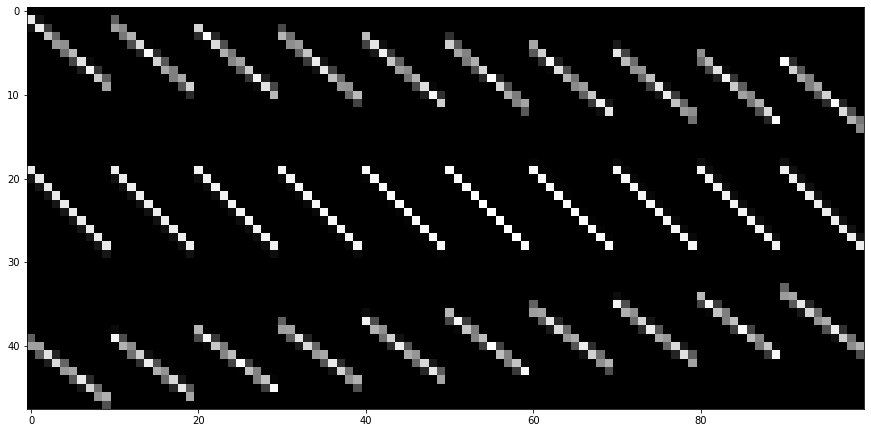

In [106]:
X = construct_X(M=10, alphas=[-33, 1, 42])

plt.gray()
plt.imshow(X.toarray())


# 2 Recovering the image

In [107]:
alphas_195 = np.load("hs_tomography/alphas_195.npy")
y_195 = np.load("hs_tomography/y_195.npy")


In [108]:
X = construct_X(195, alphas_195, NP=275)
X_non_zero = X.count_nonzero()
i, j = X.shape
print(f"X has {X_non_zero}/{i*j} non-zero entries \
-> {X_non_zero/(i*j) * 100}% density")

X has 13612950/1871780625 non-zero entries -> 0.7272727272727273% density


In [109]:
import scipy.sparse.linalg as sppl

b_high_quality = False

atol = 1e-05 if not b_high_quality else 1e-06
btol = 1e-05 if not b_high_quality else 1e-06

beta, *_ = sppl.lsqr(X.tocsc(), y_195, atol=atol, btol=btol)

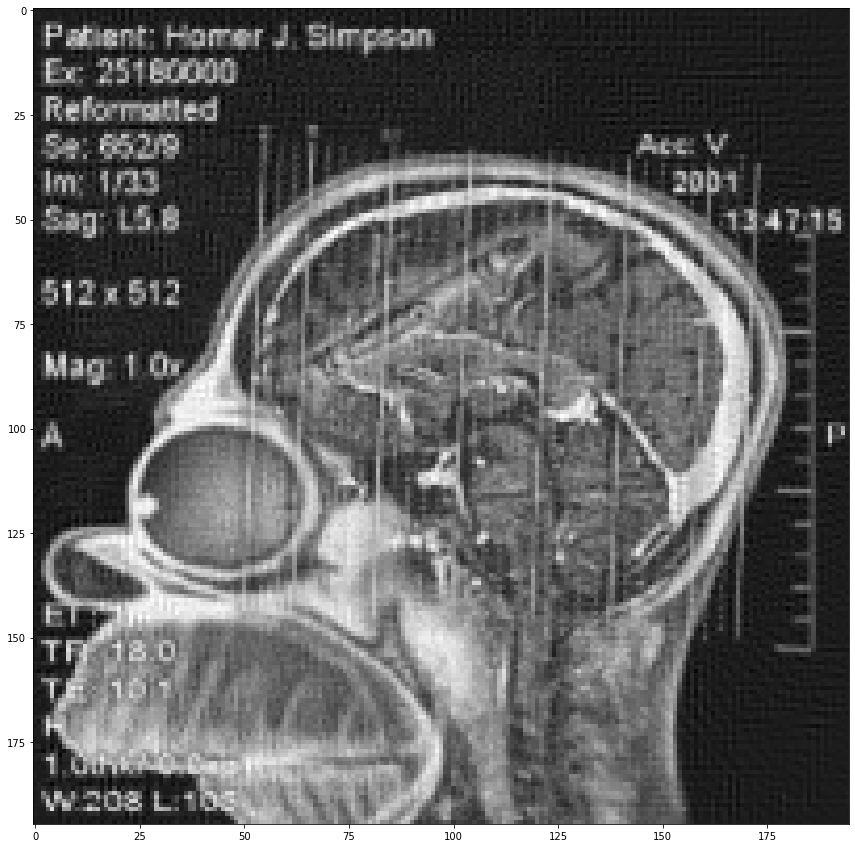

In [110]:
plt.rcParams["figure.figsize"] = 15, 15
plt.imshow(beta.reshape((195, -1)))


The Patient has a crayon in his brain. That is not the right place to store crayons.